Epoch 1/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.8824 - loss: 0.2729 - val_accuracy: 0.8024 - val_loss: 0.3427
Epoch 2/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.9433 - loss: 0.1392 - val_accuracy: 0.8729 - val_loss: 0.3205
Epoch 3/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - accuracy: 0.9469 - loss: 0.1250 - val_accuracy: 0.8747 - val_loss: 0.3926
Epoch 4/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 974s 2s/step - accuracy: 0.9496 - loss: 0.1189 - val_accuracy: 0.8766 - val_loss: 0.5301
Epoch 5/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.9499 - loss: 0.1192 - val_accuracy: 0.8687 - val_loss: 0.5693
Epoch 6/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.9541 - loss: 0.1080 - val_accuracy: 0.8729 - val_loss: 0.4947
Epoch 7/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.9583 - loss: 0.0971 - val_accuracy: 0.8638 - val_loss: 0.5859
Epoch 8/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.9588 - loss: 0.0958 - val_accu

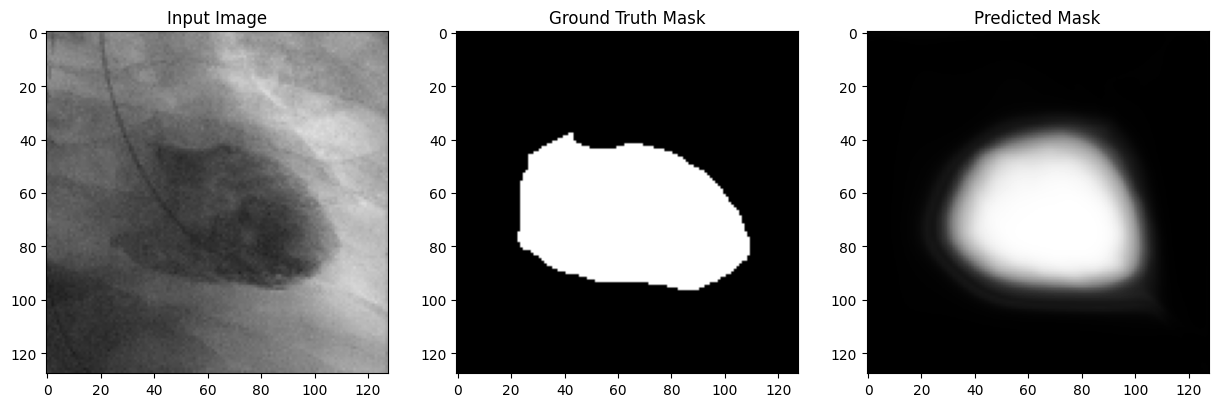

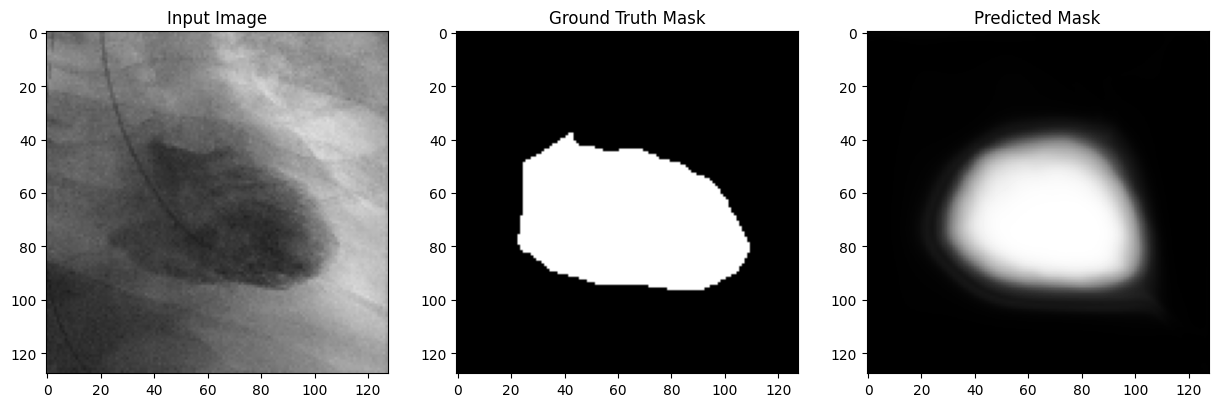

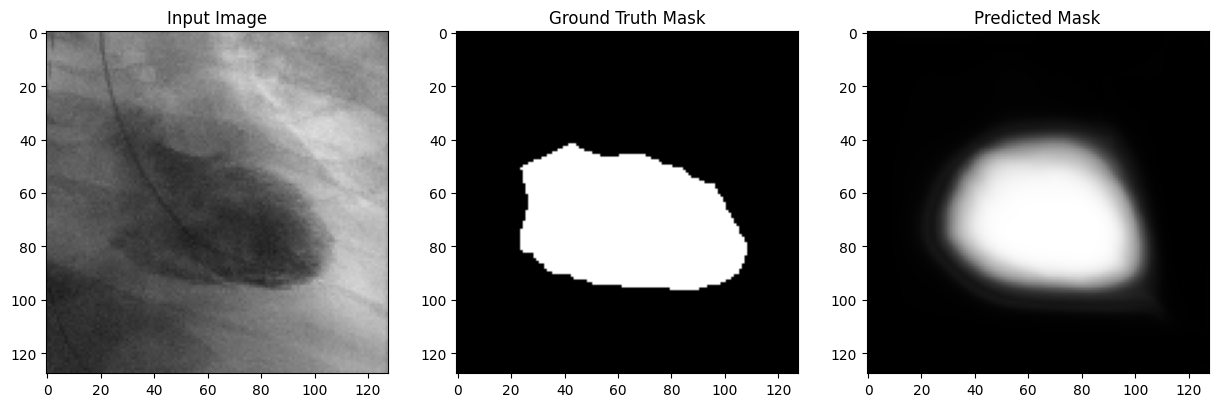

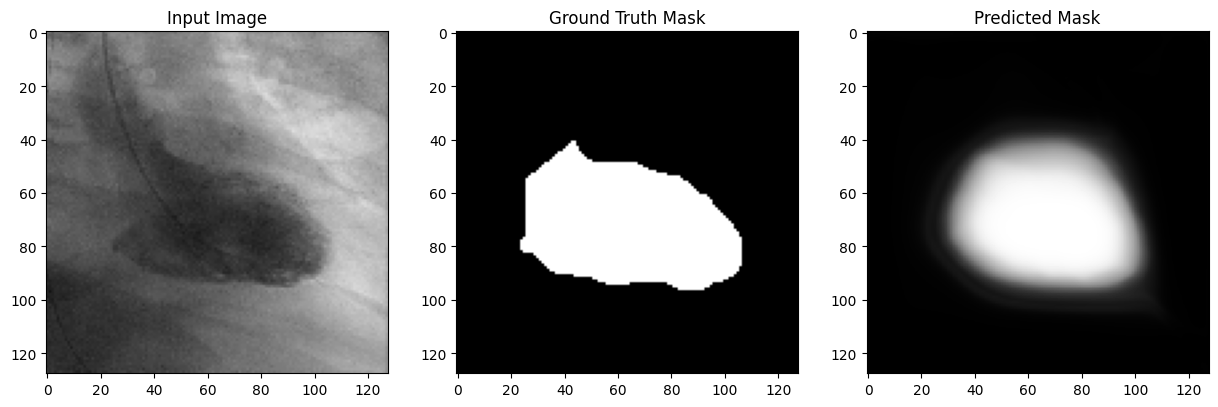

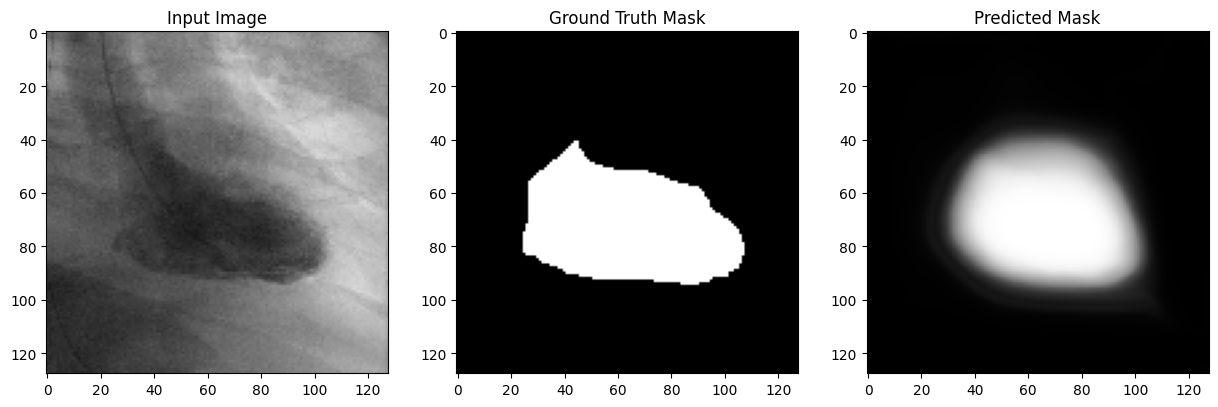

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Activation, BatchNormalization, Add, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def attention_block(x, g, inter_channel):
    """
    Attention Block: Refines encoder features based on decoder signals.
    x: Input tensor from the encoder (skip connection)
    g: Gating signal from the decoder (upsampled tensor)
    inter_channel: Number of intermediate channels (reduces computation)
    """
    # 1x1 Convolution on input tensor
    theta_x = Conv2D(inter_channel, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    # 1x1 Convolution on gating tensor
    phi_g = Conv2D(inter_channel, kernel_size=(1, 1), strides=(1, 1), padding='same')(g)

    # Add the transformed inputs and apply ReLU
    add_xg = Add()([theta_x, phi_g])
    relu_xg = Activation('relu')(add_xg)
    
    # Another 1x1 Convolution to generate attention coefficients
    psi = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding='same')(relu_xg)
    # Sigmoid activation to normalize attention weights
    sigmoid_psi = Activation('sigmoid')(psi)
    
    # Multiply the input tensor with the attention weights
    return Multiply()([x, sigmoid_psi])

def conv_block(x, filters):
    """
    Convolutional Block: Apply two 3x3 convolutions followed by BatchNorm and ReLU.
    x: Input tensor
    filters: Number of output filters for the convolutions
    """
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def attention_unet(input_shape, num_classes):
    """
    Attention U-Net model architecture.
    input_shape: Shape of input images (H, W, C)
    num_classes: Number of output segmentation classes
    """
    # Input layer for the images
    inputs = Input(input_shape)
    
    # Encoder (Downsampling path)
    c1 = conv_block(inputs, 64)              # First Conv Block
    p1 = MaxPooling2D((2, 2))(c1)            # Downsample by 2
    
    c2 = conv_block(p1, 128)                 # Second Conv Block
    p2 = MaxPooling2D((2, 2))(c2)            # Downsample by 2
    
    c3 = conv_block(p2, 256)                 # Third Conv Block
    p3 = MaxPooling2D((2, 2))(c3)            # Downsample by 2
    
    c4 = conv_block(p3, 512)                 # Fourth Conv Block
    p4 = MaxPooling2D((2, 2))(c4)            # Downsample by 2
    
    # Bottleneck (lowest level of the U-Net)
    c5 = conv_block(p4, 1024)
    
    # Decoder (Upsampling path)
    up6 = UpSampling2D((2, 2))(c5)           # Upsample
    att6 = attention_block(c4, up6, 512)     # Attention Block
    merge6 = concatenate([up6, att6], axis=-1)  # Concatenate features
    c6 = conv_block(merge6, 512)             # Conv Block after concatenation
    
    up7 = UpSampling2D((2, 2))(c6)
    att7 = attention_block(c3, up7, 256)
    merge7 = concatenate([up7, att7], axis=-1)
    c7 = conv_block(merge7, 256)
    
    up8 = UpSampling2D((2, 2))(c7)
    att8 = attention_block(c2, up8, 128)
    merge8 = concatenate([up8, att8], axis=-1)
    c8 = conv_block(merge8, 128)
    
    up9 = UpSampling2D((2, 2))(c8)
    att9 = attention_block(c1, up9, 64)
    merge9 = concatenate([up9, att9], axis=-1)
    c9 = conv_block(merge9, 64)
    
    # Output layer for segmentation
    outputs = Conv2D(num_classes, (1, 1), activation='softmax' if num_classes > 1 else 'sigmoid')(c9)
    
    # Define the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Function to load and preprocess images and masks
def load_data(image_dir, mask_dir, image_size):
    """
    Load and preprocess images and masks for training.
    image_dir: Path to the directory containing input images
    mask_dir: Path to the directory containing segmentation masks
    image_size: Tuple specifying the size (height, width) to resize the images and masks
    """
    images = []
    masks = []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    for img_file, mask_file in zip(image_files, mask_files):
        try:
            # Load and preprocess images
            img_path = os.path.join(image_dir, img_file)
            mask_path = os.path.join(mask_dir, mask_file)
            
            img = load_img(img_path, target_size=image_size)  # Resize image
            mask = load_img(mask_path, target_size=image_size, color_mode='grayscale')  # Resize mask
            
            # Convert to numpy arrays and normalize
            img = img_to_array(img) / 255.0
            mask = img_to_array(mask) / 255.0
            mask = np.round(mask)  # Ensure masks are binary
            
            images.append(img)
            masks.append(mask)
        except Exception as e:
            print(f"Error loading {img_file} or {mask_file}: {e}. Skipping...")
    
    return np.array(images), np.array(masks)

def visualize_results(images, masks, predictions, num_samples=5):
    for i in range(min(num_samples, len(images))):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title("Input Image")
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.show()

if __name__ == "__main__":
    train_path = os.path.join(os.getcwd(), 'train')
    image_dir = os.path.join(train_path, "images")
    mask_dir = os.path.join(train_path, "masks")
    image_size = (128, 128)  
    images, masks = load_data(image_dir, mask_dir, image_size)


    model = attention_unet(input_shape=(128, 128, 3), num_classes=1)
    model_checkpoint = ModelCheckpoint('best_model_AUnet.keras', save_best_only=True, monitor='val_loss', mode='min')
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(images, masks, batch_size=8, epochs=20, validation_split=0.1, callbacks=[model_checkpoint])
    best_model = tf.keras.models.load_model('best_model_AUnet.keras')
    test_loss, test_accuracy = best_model.evaluate(images, masks)
    
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    predictions = best_model.predict(images)
    visualize_results(images, masks, predictions)


In [8]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_93 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_93[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_78       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_78[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_79       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ activation_79[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_80       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_80[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_81       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ activation_81[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_97[0][0] 

 Total params: 97,326,033 (371.27 MB)

 Trainable params: 32,438,085 (123.74 MB)

 Non-trainable params: 11,776 (46.00 KB)

 Optimizer params: 64,876,172 (247.48 MB)

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace">┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)        </span>┃<span style="font-weight: bold"> Output Shape      </span>┃<span style="font-weight: bold">    Param # </span>┃<span style="font-weight: bold"> Connected to      </span>┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ -                 │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">InputLayer</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">3</span>)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_93 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │      <span style="color: #00af00; text-decoration-color: #00af00">1,792</span> │ input_layer_3[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │        <span style="color: #00af00; text-decoration-color: #00af00">256</span> │ conv2d_93[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]   │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalizatio…</span> │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_78       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ batch_normalizat… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │     <span style="color: #00af00; text-decoration-color: #00af00">36,928</span> │ activation_78[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │        <span style="color: #00af00; text-decoration-color: #00af00">256</span> │ conv2d_94[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]   │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalizatio…</span> │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_79       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ batch_normalizat… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ activation_79[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">MaxPooling2D</span>)      │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │     <span style="color: #00af00; text-decoration-color: #00af00">73,856</span> │ max_pooling2d_12… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">128</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │        <span style="color: #00af00; text-decoration-color: #00af00">512</span> │ conv2d_95[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]   │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalizatio…</span> │ <span style="color: #00af00; text-decoration-color: #00af00">128</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_80       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ batch_normalizat… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">128</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │    <span style="color: #00af00; text-decoration-color: #00af00">147,584</span> │ activation_80[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">128</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │        <span style="color: #00af00; text-decoration-color: #00af00">512</span> │ conv2d_96[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]   │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalizatio…</span> │ <span style="color: #00af00; text-decoration-color: #00af00">128</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_81       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ batch_normalizat… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">128</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ activation_81[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">MaxPooling2D</span>)      │ <span style="color: #00af00; text-decoration-color: #00af00">128</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │    <span style="color: #00af00; text-decoration-color: #00af00">295,168</span> │ max_pooling2d_13… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">256</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │      <span style="color: #00af00; text-decoration-color: #00af00">1,024</span> │ conv2d_97[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]   │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalizatio…</span> │ <span style="color: #00af00; text-decoration-color: #00af00">256</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_82       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ batch_normalizat… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">256</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │    <span style="color: #00af00; text-decoration-color: #00af00">590,080</span> │ activation_82[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">256</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │      <span style="color: #00af00; text-decoration-color: #00af00">1,024</span> │ conv2d_98[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]   │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalizatio…</span> │ <span style="color: #00af00; text-decoration-color: #00af00">256</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_83       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ batch_normalizat… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">256</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ activation_83[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">MaxPooling2D</span>)      │ <span style="color: #00af00; text-decoration-color: #00af00">256</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │  <span style="color: #00af00; text-decoration-color: #00af00">1,180,160</span> │ max_pooling2d_14… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">512</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │      <span style="color: #00af00; text-decoration-color: #00af00">2,048</span> │ conv2d_99[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]   │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalizatio…</span> │ <span style="color: #00af00; text-decoration-color: #00af00">512</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_84       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ batch_normalizat… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">512</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │  <span style="color: #00af00; text-decoration-color: #00af00">2,359,808</span> │ activation_84[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">512</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │      <span style="color: #00af00; text-decoration-color: #00af00">2,048</span> │ conv2d_100[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalizatio…</span> │ <span style="color: #00af00; text-decoration-color: #00af00">512</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_85       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ batch_normalizat… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">512</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>, <span style="color: #00af00; text-decoration-color: #00af00">512</span>) │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ activation_85[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">MaxPooling2D</span>)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_101 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>,      │  <span style="color: #00af00; text-decoration-color: #00af00">4,719,616</span> │ max_pooling2d_15… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">1024</span>)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>,      │      <span style="color: #00af00; text-decoration-color: #00af00">4,096</span> │ conv2d_101[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalizatio…</span> │ <span style="color: #00af00; text-decoration-color: #00af00">1024</span>)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_86       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>,      │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ batch_normalizat… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">1024</span>)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_102 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>,      │  <span style="color: #00af00; text-decoration-color: #00af00">9,438,208</span> │ activation_86[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">1024</span>)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>,      │      <span style="color: #00af00; text-decoration-color: #00af00">4,096</span> │ conv2d_102[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalizatio…</span> │ <span style="color: #00af00; text-decoration-color: #00af00">1024</span>)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_87       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>,      │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ batch_normalizat… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">1024</span>)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_12    │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ activation_87[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">UpSampling2D</span>)      │ <span style="color: #00af00; text-decoration-color: #00af00">1024</span>)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_103 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │    <span style="color: #00af00; text-decoration-color: #00af00">262,656</span> │ activation_85[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">512</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_104 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │    <span style="color: #00af00; text-decoration-color: #00af00">524,800</span> │ up_sampling2d_12… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">512</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (<span style="color: #0087ff; text-decoration-color: #0087ff">Add</span>)        │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ conv2d_103[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>], │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">512</span>)              │            │ conv2d_104[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_88       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ add_12[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]      │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">512</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_105 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">1</span>) │        <span style="color: #00af00; text-decoration-color: #00af00">513</span> │ activation_88[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_89       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">1</span>) │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ conv2d_105[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_12         │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ activation_85[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Multiply</span>)          │ <span style="color: #00af00; text-decoration-color: #00af00">512</span>)              │            │ activation_89[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ up_sampling2d_12… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Concatenate</span>)       │ <span style="color: #00af00; text-decoration-color: #00af00">1536</span>)             │            │ multiply_12[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_106 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │  <span style="color: #00af00; text-decoration-color: #00af00">7,078,400</span> │ concatenate_12[<span style="color: #00af00; text-decoration-color: #00af00">0</span>… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">512</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │      <span style="color: #00af00; text-decoration-color: #00af00">2,048</span> │ conv2d_106[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalizatio…</span> │ <span style="color: #00af00; text-decoration-color: #00af00">512</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_90       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ batch_normalizat… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">512</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_107 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │  <span style="color: #00af00; text-decoration-color: #00af00">2,359,808</span> │ activation_90[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">512</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │      <span style="color: #00af00; text-decoration-color: #00af00">2,048</span> │ conv2d_107[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalizatio…</span> │ <span style="color: #00af00; text-decoration-color: #00af00">512</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_91       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ batch_normalizat… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">512</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_13    │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ activation_91[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">UpSampling2D</span>)      │ <span style="color: #00af00; text-decoration-color: #00af00">512</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_108 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │     <span style="color: #00af00; text-decoration-color: #00af00">65,792</span> │ activation_83[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">256</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_109 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │    <span style="color: #00af00; text-decoration-color: #00af00">131,328</span> │ up_sampling2d_13… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">256</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (<span style="color: #0087ff; text-decoration-color: #0087ff">Add</span>)        │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ conv2d_108[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>], │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">256</span>)              │            │ conv2d_109[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_92       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ add_13[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]      │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">256</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_110 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">1</span>) │        <span style="color: #00af00; text-decoration-color: #00af00">257</span> │ activation_92[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_93       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">1</span>) │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ conv2d_110[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_13         │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ activation_83[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Multiply</span>)          │ <span style="color: #00af00; text-decoration-color: #00af00">256</span>)              │            │ activation_93[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ up_sampling2d_13… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Concatenate</span>)       │ <span style="color: #00af00; text-decoration-color: #00af00">768</span>)              │            │ multiply_13[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_111 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │  <span style="color: #00af00; text-decoration-color: #00af00">1,769,728</span> │ concatenate_13[<span style="color: #00af00; text-decoration-color: #00af00">0</span>… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">256</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │      <span style="color: #00af00; text-decoration-color: #00af00">1,024</span> │ conv2d_111[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalizatio…</span> │ <span style="color: #00af00; text-decoration-color: #00af00">256</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ batch_normalizat… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">256</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_112 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │    <span style="color: #00af00; text-decoration-color: #00af00">590,080</span> │ activation_94[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">256</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │      <span style="color: #00af00; text-decoration-color: #00af00">1,024</span> │ conv2d_112[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalizatio…</span> │ <span style="color: #00af00; text-decoration-color: #00af00">256</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ batch_normalizat… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">256</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_14    │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ activation_95[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">UpSampling2D</span>)      │ <span style="color: #00af00; text-decoration-color: #00af00">256</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_113 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │     <span style="color: #00af00; text-decoration-color: #00af00">16,512</span> │ activation_81[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">128</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_114 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │     <span style="color: #00af00; text-decoration-color: #00af00">32,896</span> │ up_sampling2d_14… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">128</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (<span style="color: #0087ff; text-decoration-color: #0087ff">Add</span>)        │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ conv2d_113[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>], │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">128</span>)              │            │ conv2d_114[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ add_14[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]      │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">128</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_115 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">1</span>) │        <span style="color: #00af00; text-decoration-color: #00af00">129</span> │ activation_96[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">1</span>) │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ conv2d_115[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_14         │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ activation_81[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Multiply</span>)          │ <span style="color: #00af00; text-decoration-color: #00af00">128</span>)              │            │ activation_97[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ up_sampling2d_14… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Concatenate</span>)       │ <span style="color: #00af00; text-decoration-color: #00af00">384</span>)              │            │ multiply_14[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │    <span style="color: #00af00; text-decoration-color: #00af00">442,496</span> │ concatenate_14[<span style="color: #00af00; text-decoration-color: #00af00">0</span>… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">128</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │        <span style="color: #00af00; text-decoration-color: #00af00">512</span> │ conv2d_116[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalizatio…</span> │ <span style="color: #00af00; text-decoration-color: #00af00">128</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ batch_normalizat… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">128</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_117 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │    <span style="color: #00af00; text-decoration-color: #00af00">147,584</span> │ activation_98[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">128</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │        <span style="color: #00af00; text-decoration-color: #00af00">512</span> │ conv2d_117[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalizatio…</span> │ <span style="color: #00af00; text-decoration-color: #00af00">128</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_99       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>,    │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ batch_normalizat… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">128</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_15    │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ activation_99[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">UpSampling2D</span>)      │ <span style="color: #00af00; text-decoration-color: #00af00">128</span>)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_118 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │      <span style="color: #00af00; text-decoration-color: #00af00">4,160</span> │ activation_79[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_119 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │      <span style="color: #00af00; text-decoration-color: #00af00">8,256</span> │ up_sampling2d_15… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (<span style="color: #0087ff; text-decoration-color: #0087ff">Add</span>)        │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ conv2d_118[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>], │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │ conv2d_119[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_100      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ add_15[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]      │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_120 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │         <span style="color: #00af00; text-decoration-color: #00af00">65</span> │ activation_100[<span style="color: #00af00; text-decoration-color: #00af00">0</span>… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">1</span>)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_101      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ conv2d_120[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">1</span>)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_15         │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ activation_79[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Multiply</span>)          │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │ activation_101[<span style="color: #00af00; text-decoration-color: #00af00">0</span>… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ up_sampling2d_15… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Concatenate</span>)       │ <span style="color: #00af00; text-decoration-color: #00af00">192</span>)              │            │ multiply_15[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │    <span style="color: #00af00; text-decoration-color: #00af00">110,656</span> │ concatenate_15[<span style="color: #00af00; text-decoration-color: #00af00">0</span>… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │        <span style="color: #00af00; text-decoration-color: #00af00">256</span> │ conv2d_121[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalizatio…</span> │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_102      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ batch_normalizat… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_122 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │     <span style="color: #00af00; text-decoration-color: #00af00">36,928</span> │ activation_102[<span style="color: #00af00; text-decoration-color: #00af00">0</span>… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │        <span style="color: #00af00; text-decoration-color: #00af00">256</span> │ conv2d_122[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">BatchNormalizatio…</span> │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_103      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ batch_normalizat… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Activation</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">64</span>)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_123 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>,  │         <span style="color: #00af00; text-decoration-color: #00af00">65</span> │ activation_103[<span style="color: #00af00; text-decoration-color: #00af00">0</span>… │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">1</span>)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘
</pre>